# Running Task 2 with a Pre-Trained Model

This notebook walks through an example of utilizing the existing trained models ([pre-trained weights](https://www.dropbox.com/sh/pzza5nuh93r9s18/AAAZsISLUl1H_u3U0TDSeOjNa?dl=0)) to perform pixel-level brain microstructure (blood-vessel, cell, axon) segmentations.

## Intro

In MTNeuro, we provied multiple tasks to evaluate the model across multiple scales and capabilities. This notebook deals with `Task 2`, .i.e, the **Pixel Level Brain Microstructure Segmentation Task**, and provides methods to download and load the pretrained weights and models configs to easily perform pixel-level segmentation and explore the outcomes.

#### Citation
For more details about `Task 2` and the other tasks, please refer:

```
Quesada, J., Sathidevi, L., Liu, R., Ahad, N., Jackson, J.M., Azabou, M., ... & Dyer, E. L. (2022). MTNeuro: A Benchmark for Evaluating Representations of Brain Structure Across Multiple Levels of Abstraction. Thirty-sixth Conference on Neural Information Processing Systems Datasets and Benchmarks Track.

Prasad, J. A., Balwani, A. H., Johnson, E. C., Miano, J. D., Sampathkumar, V., De Andrade, V., ... & Dyer, E. L. (2020). A three-dimensional thalamocortical dataset for characterizing brain heterogeneity. Scientific Data, 7(1), 1-7.
```


### Specifying the Model, Setting, and Mode for Image Segmentation


**3class Setting**: Segmentation using 3 labels - cell bodies, blood vessels and background (axons considered as background)

**4class Setting**: Segmentation using 4 labels - cell bodies, blood vessels, axons and background. In this setting the ZI region is excluded as clearly distinguishing the axons in the slices from ZI region would be difficult even for a knowledgeable human annotator.

**Available Options**:

2D Models | 3D Models | Settings | Modes
----------|-----------|----------|--------
UNet | UNet | 3class | 2D
smp_UnetPlusPlus | mzp_HighResNet | 4class | 3D
smp_PSPNet | mzp_VNetLight |
smp_PAN |
smp_FPN |
smp_MAnet |

Note: `smp` indicates models imported from [segmentation_models.pytorch](https://github.com/qubvel/segmentation_models.pytorch) library and `mzp` indicates models imported from [medicalzoopytorch](https://github.com/black0017/MedicalZooPytorch) library.

Specify your preferred model and setting below (refer to table above for available options):

In [1]:
Model = 'UNet'         #Eg:- UNet, smp_PAN
Setting = '3class'     #Eg:- 3class, 4class
Mode = '2D'            #Eg:- 3D, 2D

fh = open('config.txt', 'w')
fh.write(Model+' '+Setting+' '+Mode)
fh.close()

### Cloning Required Repositories, Installing Libraries and Dependencies, and Importing Packages

Installing required packages:

In [ ]:
# If not already installed, Download and install Pytorch with CUDA support: https://pytorch.org/get-started/locally/
    
!pip install intern[cloudvolume]
!pip install scikit-learn
!pip install timm
!pip install pretrainedmodels
!pip install efficientnet_pytorch

# Setting up the segmentation_models.pytorch library
!pip install segmentation-models-pytorch

#setting up medicalzoopytorch
!pip install github-clone
!ghclone https://github.com/black0017/MedicalZooPytorch/tree/master/lib/medzoo

Import the required Packages:

In [ ]:
#import libraries
import sys
import matplotlib.pyplot as plt
import numpy as np
import json as json
from tqdm import tqdm
import glob

#pytorch imports
import torch
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader

#intern library that is used to pull 3D brain volume form BossDB
from intern import array

Import the required models / their respective libraries, and the BossDB dataloader (used to download the required slices of brain imaging data from BossDB):

In [ ]:
#importing HighResNet and VNetLight models from medzoopytorch library
sys.path.append('lib/medzoo')
from HighResNet3D import HighResNet3D
from Vnet import VNetLight

sys.path.append('../MTNeuro/')                 #setting the location to look for the required packages

#BossDB library and MTNeuro dataset loader
from bossdbdataset import BossDBDataset               

from models.unet import UNet                   #UNet model. From: https://github.com/johschmidt42/PyTorch-2D-3D-UNet-Tutorial
import segmentation_models_pytorch as smp      #SMP library: https://github.com/qubvel/segmentation_models.pytorch

### Download the Trained Weights

The trained weights and configuration files for the models can be downloaded from: [Link](https://www.dropbox.com/sh/pzza5nuh93r9s18/AAAZsISLUl1H_u3U0TDSeOjNa?dl=0). 

Below script automatically does that for you (using the model and setting specified earlier):

In [3]:
%%bash
IFS=' ' read -r model setting mode <<< `cat config.txt`
#echo $model
#eho $setting
#echo $mode
rm -f *.json
if [ "$mode" == "2D" ]; then
  if [ "$setting" == "3class" ]; then
    if [ "$model" == "UNet" ]; then
      echo "Loading $model $mode $setting" && wget https://www.dropbox.com/s/7zwh7j43ozui7t1/UNet_2D_3class.pt -q --show-progress --progress=dot 
      wget https://www.dropbox.com/s/7edhhxr7o9iqear/UNet_2D_3class.json -q --show-progress --progress=dot
    elif [ "$model" == "smp_UnetPlusPlus" ]; then
      echo "Loading $model $mode $setting" && wget https://www.dropbox.com/s/r0v3vvwlqelpbac/smp_UnetPlusPlus_3class.pt -q --show-progress --progress=dot
      wget https://www.dropbox.com/s/aneo0ld7e13sq8p/smp_UnetPlusPlus_3class.json -q --show-progress --progress=dot
    elif [ "$model" == "smp_PSPNet" ]; then
      echo "Loading $model $mode $setting" && wget https://www.dropbox.com/s/h4qmkbj7y878ivt/smp_PSPNet_3class.pt -q --show-progress --progress=dot
      wget https://www.dropbox.com/s/7jg2tjyji2j7hlx/smp_PSPNet_3class.json -q --show-progress --progress=dot
    elif [ "$model" == "smp_PAN" ]; then
      echo "Loading $model $mode $setting" && wget https://www.dropbox.com/s/xph537dtsq1qxja/smp_PAN_3class.pt -q --show-progress --progress=dot
      wget https://www.dropbox.com/s/ztndoyzgm464exs/smp_PAN_3class.json -q --show-progress --progress=dot
    elif [ "$model" == "smp_FPN" ]; then
      echo "Loading $model $mode $setting" && wget https://www.dropbox.com/s/iu8ute75j4tbpxf/smp_FPN_3class.pt -q --show-progress --progress=dot
      wget https://www.dropbox.com/s/4d1cmksl887ltir/smp_FPN_3class.json -q --show-progress --progress=dot
    elif [ "$model" == "smp_MAnet" ]; then
      echo "Loading $model $mode $setting" && wget https://www.dropbox.com/s/d9kll74duwo2cbr/smp_MAnet_3class.pt -q --show-progress --progress=dot
      wget https://www.dropbox.com/s/yf9gf8kdk3ad4uk/smp_MAnet_3class.json -q --show-progress --progress=dot
    fi
  elif [ "$setting" == "4class" ]; then
    if [ "$model" == "UNet" ]; then
      echo "Loading $model $mode $setting"
      wget https://www.dropbox.com/s/xd0hgpq36hjjt21/UNet_2D_noZI.pt -q --show-progress --progress=dot
      wget https://www.dropbox.com/s/30ofn890moxxyzp/UNet_2D.json -q --show-progress --progress=dot
    elif [ "$model" == "smp_UnetPlusPlus" ]; then
      echo "Loading $model $mode $setting"
      wget https://www.dropbox.com/s/7rbhu074454h6we/smp_UnetPlusPlus_noZI.pt -q --show-progress --progress=dot
      wget https://www.dropbox.com/s/8fugnn18127rvg4/smp_UnetPlusPlus.json -q --show-progress --progress=dot
    elif [ "$model" == "smp_PSPNet" ]; then
      echo "Loading $model $mode $setting"
      wget https://www.dropbox.com/s/u043cojfd12xkoc/smp_PSPNet_noZI.pt -q --show-progress --progress=dot
      wget https://www.dropbox.com/s/114iwuka5gjf5fj/smp_PSPNet.json -q --show-progress --progress=dot
    elif [ "$model" == "smp_PAN" ]; then
      echo "Loading $model $mode $setting"
      wget https://www.dropbox.com/s/w5fi601apllhzka/smp_PAN_noZI.pt -q --show-progress --progress=dot
      wget https://www.dropbox.com/s/8pq5epecvm0sndj/smp_PAN.json -q --show-progress --progress=dot
    elif [ "$model" == "smp_FPN" ]; then
      echo "Loading $model $mode $setting"
      wget https://www.dropbox.com/s/k14btyrs4lif0z0/smp_FPN_noZI.pt -q --show-progress --progress=dot
      wget https://www.dropbox.com/s/u1ivarsp1m6h8nd/smp_FPN.json -q --show-progress --progress=dot
    elif [ "$model" == "smp_MAnet" ]; then
      echo "Loading $model $mode $setting"
      wget https://www.dropbox.com/s/3qyxozy02app7e6/smp_MAnet_noZI.pt -q --show-progress --progress=dot
      wget https://www.dropbox.com/s/usxyqpwho8k2tc0/smp_MAnet.json -q --show-progress --progress=dot
    fi
  fi
elif [ "$mode" == "3D" ]; then
  if [ "$setting" == "3class" ]; then
    if [ "$model" == "mzp_HighResNet" ]; then
      echo "Loading $model $mode $setting"
      wget https://www.dropbox.com/s/ffblz0irsjemvpw/mzp_HighResNet_3D_3class.pt -q --show-progress --progress=dot
      wget https://www.dropbox.com/s/u13ezr19azk1a8w/mzp_HighResNet_3D_3class.json -q --show-progress --progress=dot
    elif [ "$model" == "mzp_VNetLight" ]; then
      echo "Loading $model $mode $setting"
      wget https://www.dropbox.com/s/otrga1kr9lishim/mzp_VNetLight_3D_3class.pt -q --show-progress --progress=dot
      wget https://www.dropbox.com/s/71f5sae3l9hl4a0/mzp_VNetLight_3D_3class.json -q --show-progress --progress=dot
    elif [ "$model" == "UNet" ]; then
      echo "Loading $model $mode $setting"
      wget https://www.dropbox.com/s/f5db56f41pcmyxo/UNet_3D_3class.pt -q --show-progress --progress=dot
      wget https://www.dropbox.com/s/v7360u0g62d19h3/UNet_3D_3class.json -q --show-progress --progress=dot
    fi
  elif [ "$setting" == "4class" ]; then
    if [ "$model" == "mzp_HighResNet" ]; then
      echo "Loading $model $mode $setting"
      wget https://www.dropbox.com/s/255medlec507t33/mzp_HighResNet_3D_noZI.pt -q --show-progress --progress=dot
      wget https://www.dropbox.com/s/kgkw0f28eppr7j8/mzp_HighResNet_3D.json -q --show-progress --progress=dot
    elif [ "$model" == "mzp_VNetLight" ]; then
      echo "Loading $model $mode $setting"
      wget https://www.dropbox.com/s/1xbmjcvjpi5fix5/mzp_VNetLight_3D_noZI.pt -q --show-progress --progress=dot
      wget https://www.dropbox.com/s/tt2xocpu18gokmw/mzp_VNetLight_3D.json -q --show-progress --progress=dot
    elif [ "$model" == "UNet" ]; then
      echo "Loading $model $model $mode $setting"
      wget https://www.dropbox.com/s/grlqwue5s2sttyb/UNet_3D_noZI.pt -q --show-progress --progress=dot
      wget https://www.dropbox.com/s/0ab9t3oeo66zkz5/UNet_3D.json -q --show-progress --progress=dot
    fi
  fi
fi

SyntaxError: invalid syntax (2680183395.py, line 8)

### Load the appropriate Configuration File

**task config**: Settings corresponding to the task, like the x, y and z region of the slices. [Example](https://github.com/MTNeuro/MTNeuro/blob/main/MTNeuro/taskconfig/task2_2D_3class.json)

**network config**: Settings corresponding to the model and the training, like model layer sizes, training batch size, etc. [Example](https://github.com/MTNeuro/MTNeuro/blob/main/MTNeuro/networkconfig/UNet_2D_3class.json)

In [4]:
##load the task config for specified mode and setting that specifies the x,y ranges to pick from the data for forming the slices
task_config = json.load(open('../MTNeuro/taskconfig/task2_'+str(Mode)+'_'+str(Setting)+'.json'))

##Load the network config for the specified mode and setting, with the batch size and model config information
network_config = json.load(open(glob.glob("*.json")[0]))

NameError: name 'json' is not defined

### Load the Model and the corresponding pre-trained weights

#### Loading the Model

In [19]:
# Specify device
device = torch.device('cuda') if torch.cuda.is_available() else  torch.device('cpu')

# Specify model
if network_config["model"] == "UNet":
  print('loading UNet model')
  model = UNet(in_channels=network_config['in_channels'],
                out_channels=network_config['classes'],
                n_blocks=network_config['n_blocks'],
                start_filters=network_config['start_filters'],
                activation=network_config['activation'],
                normalization=network_config['normalization'],
                conv_mode=network_config['conv_mode'],
                dim=network_config['dim']).to(device)

if network_config["model"] == "smp_UnetPlusPlus":
  print('loading UnetPlusPlus model')
  model = smp.UnetPlusPlus(
            encoder_name=network_config["encoder_name"],         # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights=network_config["encoder_weights"],   # use `imagenet` pre-trained weights for encoder initialization
            in_channels=network_config["in_channels"],           # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=network_config["classes"],                   # model output channels (number of classes in your dataset)
        ).to(device)

if network_config["model"] == "smp_MAnet":
  print('loading MAnet model')
  model = smp.MAnet(
            encoder_name=network_config["encoder_name"],         # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights=network_config["encoder_weights"],   # use `imagenet` pre-trained weights for encoder initialization
            in_channels=network_config["in_channels"],           # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=network_config["classes"],                   # model output channels (number of classes in your dataset)
        ).to(device)

if network_config["model"] == "smp_PAN":
  print('loading PAN model')
  model = smp.PAN(
            encoder_name=network_config["encoder_name"],         # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights=network_config["encoder_weights"],   # use `imagenet` pre-trained weights for encoder initialization
            in_channels=network_config["in_channels"],           # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=network_config["classes"],                   # model output channels (number of classes in your dataset)
        ).to(device)

if network_config["model"] == "smp_Linknet":
  print('loading Linknet model')
  model = smp.Linknet(
            encoder_name=network_config["encoder_name"],         # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights=network_config["encoder_weights"],   # use `imagenet` pre-trained weights for encoder initialization
            in_channels=network_config["in_channels"],           # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=network_config["classes"],                   # model output channels (number of classes in your dataset)
        ).to(device)

if network_config["model"] == "smp_FPN":
  print('loading FPN model')
  model = smp.FPN(
            encoder_name=network_config["encoder_name"],         # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights=network_config["encoder_weights"],   # use `imagenet` pre-trained weights for encoder initialization
            in_channels=network_config["in_channels"],           # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=network_config["classes"],                   # model output channels (number of classes in your dataset)
        ).to(device)

if network_config["model"] == "smp_PSPNet":
  print('loading PSPNet model')
  model = smp.PSPNet(
            encoder_name=network_config["encoder_name"],        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
            encoder_weights=network_config["encoder_weights"],     # use `imagenet` pre-trained weights for encoder initialization
            in_channels=network_config["in_channels"],                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
            classes=network_config["classes"],                      # model output channels (number of classes in your dataset)
        ).to(device)

if network_config["model"] == 'mzp_VNetLight_3D':
  model= VNetLight(in_channels=network_config["in_channels"], elu=False, classes=network_config["classes"]).to(device)

if network_config["model"] == "mzp_HighResNet_3D":
  model= HighResNet3D(in_channels=network_config["in_channels"], classes=network_config["classes"]).to(device)

loading UNet model


#### Loading the pre-trained weights to the model

In [21]:
#load saved weights here. Example path (after download): Models/Task2/2D/UNet_2D/3_Class_Setting/smp_UNet_2D_3class_seed1/UNet_2D_3class.pt
if Mode=='3D':
  if Setting=='4class':
    checkpoint = torch.load(str(Model)+'_'+str(Mode)+'_noZI.pt', map_location='cuda:0')
    model.load_state_dict(checkpoint)
  if Setting=='3class':
    checkpoint = torch.load(str(Model)+'_'+str(Mode)+'_3class.pt', map_location='cuda:0')
    model.load_state_dict(checkpoint)
if Mode=='2D':
  if Setting=='3class' and Model == "UNet":
    checkpoint = torch.load(str(Model)+'_'+str(Mode)+'_'+str(Setting)+'.pt', map_location='cuda:0')
    model.load_state_dict(checkpoint)
  elif Setting=='3class':
    checkpoint = torch.load(str(Model)+'_'+str(Setting)+'.pt', map_location='cuda:0')
    model.load_state_dict(checkpoint)
  elif Setting=='4class' and Model=="UNet":
    checkpoint = torch.load(str(Model)+'_'+str(Mode)+'_noZI.pt', map_location='cuda:0')
    model.load_state_dict(checkpoint)
  else:
   checkpoint = torch.load(str(Model)+'_noZI.pt', map_location='cuda:0')
   model.load_state_dict(checkpoint)
print('Successfully loaded pre-trained weights into the Model')

Successfully loaded pre-trained weights into the Model


### Preparing the DataLoader using BossDBDataset

**BossDBDataset**: Helper function that utilizes the `intern` library to download 3D brain volume from BossDB and convert it into a suitable dataloader of image slices.

Note: The `ToTensor` transform needs to be applied in order to enable the conversion from numpy to PyTorch tensor.

In [22]:
transform = transforms.Compose([transforms.ToTensor(),])

##Set-up the test dataloader
test_data = BossDBDataset(task_config, None, 'test', image_transform = transform, mask_transform = transform)

test_dataloader = DataLoader(dataset=test_data,
                                        batch_size=network_config['batch_size'],
                                        shuffle=False)

### Model Prediction

#### Prediction Function


In [23]:
#function to predict using trained model
def predict(img, model, device):
        model.eval()
        x = img.to(device)  # to torch, send to device
        with torch.no_grad():
            out = model(x)  # send through model/network

        out_argmax = torch.argmax(out, dim=1)  # perform softmax on outputs
        return out_argmax

#### Prediction Loop


In [24]:
batch_iter = tqdm(enumerate(test_dataloader), 'test', total=len(test_dataloader), leave=False)
# predict the segmentations of test set
tp_tot = torch.empty(0,network_config['classes'])
fp_tot = torch.empty(0,network_config['classes'])
fn_tot = torch.empty(0,network_config['classes'])
tn_tot = torch.empty(0,network_config['classes'])

y_ = []
x_ = []
output_ = []
for i, (x, y) in batch_iter:
    target = y.to(device) #can do this on CPU
    y_.append(y)
    x_.append(x.squeeze())
    with torch.no_grad():
        # get the output image (make prediction)
        output = predict(x, model, device)
        output_.append(output)
        tp_, fp_, fn_, tn_ = smp.metrics.get_stats(output, target, mode='multiclass', num_classes = network_config['classes'])
        tp_tot = torch.vstack((tp_tot,tp_))
        fp_tot = torch.vstack((fp_tot,fp_))
        fn_tot = torch.vstack((fn_tot,fn_))
        tn_tot = torch.vstack((tn_tot,tn_))

#### Calculating Performance Metrics

In [25]:
# Accuracy: (tp + fp) / (fp + tn + fn + tp)
acc = (tp_tot.mean(dim=0)+tn_tot.mean(dim=0))/(fp_tot.mean(dim=0)+tn_tot.mean(dim=0)+fn_tot.mean(dim=0)+tp_tot.mean(dim=0)) 
print('Accuracy per Class:')
print(np.array(acc.cpu()))

# Balanced Accuracy:  (Specificity + Sensitivity / 2)
spec =  (tn_tot[:,1:].mean())/(fp_tot[:,1:].mean()+tn_tot[:,1:].mean())
sens =  (tp_tot[:,1:].mean())/(fn_tot[:,1:].mean()+tp_tot[:,1:].mean())
balacc = (spec + sens)/2
print(f'Balanced accuracy (No background): {balacc}')

# F1-score: 2* precision * recall / (precision + recall)
prec = tp_tot.mean(dim=0)/(fp_tot.mean(dim=0)+tp_tot.mean(dim=0))
reca = tp_tot.mean(dim=0)/(fn_tot.mean(dim=0)+tp_tot.mean(dim=0))
f1 = (2*reca*prec)/(reca+prec)
print(f'F1-score: {np.array(f1.cpu())} Avg. F1-score: {f1.mean()}')

# IoU: tp /(fp + fn + tp)
iou = (tp_tot.mean(0))/(fp_tot.mean(0)+fn_tot.mean(0)+tp_tot.mean(0))
print(f'IoU: {np.array(iou.cpu())} Avg. IoU-score: {iou.mean()}')

Accuracy per Class:
[0.9477365 0.9693083 0.9637189]
Balanced accuracy (No background): 0.8441511392593384
F1-score: [0.9708818 0.6183254 0.7090855] Avg. F1-score: 0.7660975456237793
IoU: [0.94341135 0.4475188  0.5492892 ] Avg. IoU-score: 0.6467397809028625


#### Visualizing Model Predictions

torch.Size([2, 256, 256])


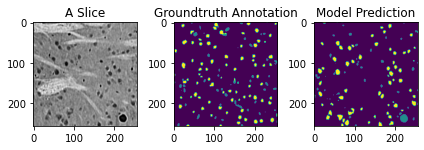

In [26]:
#specify the slice from the test set to visualize
batch_number = 0
slice_number = 1
print(x_[batch_number].shape)

plt.subplot(1,3,1)
plt.imshow(x_[batch_number].squeeze().cpu()[slice_number], cmap='gray')
plt.title("A Slice")
plt.subplot(1,3,2)
if Setting=='3class':
  plt.imshow(y_[batch_number].squeeze().cpu()[slice_number], vmin=0, vmax=2)
else:
  plt.imshow(y_[batch_number].squeeze().cpu()[slice_number], vmin=0, vmax=3)
plt.title("Groundtruth Annotation")
plt.subplot(1,3,3)
if Setting=='3class':
  plt.imshow(output_[batch_number].squeeze().cpu()[slice_number], vmin=0, vmax=2)
else:
  plt.imshow(output_[batch_number].squeeze().cpu()[slice_number], vmin=0, vmax=3)
plt.title("Model Prediction")
plt.tight_layout()